# Train the StarNet Model

This notebook takes you through the steps of how to train a StarNet Model
- Required Python packages: `numpy h5py keras`
- Required data files: training_data.h5, mean_and_std.npy

Note: We use tensorflow for the keras backend.

In [436]:
import numpy as np
import h5py
import random
import keras
from keras.models import Model
from keras.layers import Input, Dense, InputLayer, Flatten, Reshape, Concatenate, concatenate
from keras.layers.convolutional import Conv1D
from keras.layers.convolutional import MaxPooling1D
from keras.optimizers import Adam
import tensorflow as tf
from keras.optimizers import RMSprop
from keras.callbacks import EarlyStopping, ReduceLROnPlateau
from keras.utils import HDF5Matrix
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import rc


#Loading the data

#RVSFlux normalized
pathrvs = 'norm_rvsflux.h5'
readrvs = h5py.File(pathrvs, 'r')
print(readrvs.keys())
rvs = readrvs.get('normrvs')
norm_rvsflux = np.array(rvs)
readrvs.close()

type(rvs)
print('shape of rvsflux:', np.shape(norm_rvsflux))


<KeysViewHDF5 ['normrvs']>
shape of rvsflux: (415, 1134)


In [437]:

#BPFlux noiseless
pathbp = '/Users/aishasultan/work/synple-gaia/run/flux_feh0/bpflux.h5'
readbp = h5py.File(pathbp, 'r')
#print('total number of wave and flux in the folder:'len(readbp.keys()))
bpflux = readbp.get('bpflux0')
bpflux = np.array(bpflux)


norm_bpflux= []

for ii in range(np.shape(norm_rvsflux)[0]):
    #if ii%50 == 0: #i=i/100
        #print('star #',ii)
        fluxlabel = 'bpflux'+str(ii)
        wavelabel = 'bpwave' +str(ii)
        flux = readbp.get(fluxlabel)
        wave= readbp.get(wavelabel)
    
        
        flux = np.array(flux)
        wave = np.array(wave)
        #print('flux is:', flux)
        
        max_flux=np.max(flux)
        #print('maxflux:', max_flux)
        normflux = flux/ max_flux
        #print('normflux:',normflux)
        
        
        
        #plt.plot(wave, flux)
        #plt.scatter(wave,flux, color='red')
        #plt.show()
    
        
        norm_bpflux.append(normflux)


        
norm_bpflux= np.array(norm_bpflux)

print('shape of norm bpflux:', np.shape(norm_bpflux))
#print('shape of norm bpflux:', print(norm_bpflux[0:10]))









shape of norm bpflux: (415, 53)


In [438]:
#RPFlux
pathrp = '/Users/aishasultan/work/synple-gaia/run/flux_feh0/rpflux.h5'
readrp = h5py.File(pathrp, 'r')
#print('total number of wave and flux in the folder:'len(readbp.keys()))
rpflux = readrp.get('rpflux0')
rpflux = np.array(rpflux)


norm_rpflux= []

for ii in range(np.shape(norm_rvsflux)[0]):
    #if ii%50 == 0: #i=i/100
        #print('star:',ii)
        fluxlabel = 'rpflux'+str(ii)
        wavelabel = 'rpwave' +str(ii)
        
        flux = readrp.get(fluxlabel)
        wave= readrp.get(wavelabel)
    
        
        flux = np.array(flux)
        wave = np.array(wave)
        #print('flux is:', flux)
        
        max_flux=np.max(flux)
        #print('maxflux:', max_flux)
        normflux = flux/ max_flux
        #print('normflux:',normflux)
        
        
        
        #plt.plot(wave, flux)
        #plt.scatter(wave,flux, color='red')
        #plt.show()
    
        
        norm_rpflux.append(normflux)


        
norm_rpflux= np.array(norm_rpflux)

print('shape of norm_rpflux:', np.shape(norm_rpflux))
#print('output of norm_flux:', print(norm_rpflux[0:10]))

#print('The shapes of features and labels:', np.shape(norm_flux), np.shape(logteff))





shape of norm_rpflux: (415, 49)


In [439]:
#LogTeff
modparam = 'modparam_feh0.h5' #model parameters includes log g and teff
readfile = h5py.File(modparam, 'r')
print(readfile.keys())
teff = readfile.get('teff')
teff = np.array(teff)
logg = readfile.get('logg')
logg = np.array(logg)
print(teff)
readfile.close()


<KeysViewHDF5 ['logg', 'teff']>
[ 3500.  3500.  3500.  3500.  3500.  3500.  3500.  3500.  3500.  3500.
  3500.  3750.  3750.  3750.  3750.  3750.  3750.  3750.  3750.  3750.
  3750.  3750.  4000.  4000.  4000.  4000.  4000.  4000.  4000.  4000.
  4000.  4000.  4000.  4250.  4250.  4250.  4250.  4250.  4250.  4250.
  4250.  4250.  4250.  4250.  4500.  4500.  4500.  4500.  4500.  4500.
  4500.  4500.  4500.  4500.  4500.  4750.  4750.  4750.  4750.  4750.
  4750.  4750.  4750.  4750.  4750.  4750.  5000.  5000.  5000.  5000.
  5000.  5000.  5000.  5000.  5000.  5000.  5000.  5250.  5250.  5250.
  5250.  5250.  5250.  5250.  5250.  5250.  5250.  5250.  5500.  5500.
  5500.  5500.  5500.  5500.  5500.  5500.  5500.  5500.  5500.  5750.
  5750.  5750.  5750.  5750.  5750.  5750.  5750.  5750.  5750.  5750.
  6000.  6000.  6000.  6000.  6000.  6000.  6000.  6000.  6000.  6000.
  6000.  6250.  6250.  6250.  6250.  6250.  6250.  6250.  6250.  6250.
  6500.  6500.  6500.  6500.  6500.  6500.  6

total number of input stars = 415
number of RVS training data= 337
number of BP training data= 337
number of RP training data= 337
The size of CVS for the input flux data
RVS cvs= (78, 1134)
BP cvs= (78, 53)
RP cvs= (78, 49)
the size of output label= (337,)


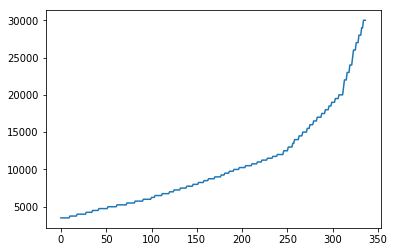

In [440]:

#features
num_tot = len(teff)
print('total number of input stars =', num_tot)
plim = 0.8
ran_frac = np.random.uniform(0,1,num_tot)
#print('ranfrac=' , ran_frac)




#Input flux data of RVS, BP, RP
x_RVStrain = norm_rvsflux[ran_frac < plim, :]
print('number of RVS training data=', len(x_RVStrain[:,0]))
x_RVScv = norm_rvsflux[ran_frac >= plim, :] #test set we left for the application

x_BPtrain = norm_bpflux[ran_frac < plim, :]
print('number of BP training data=', len(x_BPtrain[:,0]))
x_BPcv = norm_bpflux[ran_frac >= plim, :]

x_RPtrain =norm_rpflux[ran_frac < plim, :]
print('number of RP training data=', len(x_RPtrain[:,0]))
x_RPcv = norm_rpflux[ran_frac >= plim, :]


#print('x_BPtrain', x_BPtrain)

#x_train_combined = np.vstack (x_RVStrain[0,:],x_RPtrain[0,:]) 

#output label which is the logteff and log g
y_teff_train = teff[ran_frac< plim]
y_teff_cv = teff[ran_frac >= plim] #test set

y_logg_train = logg[ran_frac< plim]
y_logg_cv = logg[ran_frac >= plim] #test set



print('The size of CVS for the input flux data')
print('RVS cvs=', np.shape(x_RVScv))
print('BP cvs=', np.shape(x_BPcv))
print('RP cvs=', np.shape(x_RPcv))

print('the size of output label=', np.shape(y_teff_train) )

id = np.linspace(0, len(x_RVStrain[:, 0])-1, len(x_RVStrain[:, 0]))
plt.plot(id, y_teff_train)
plt.show()


** Normalization **

Write a function to normalize the output labels. Each label will be normalized to have approximately have a mean of zero and unit variance.

NOTE: This is necessary to put output labels on a similar scale in order for the model to train properly, this process is reversed in the test stage to give the output labels their proper units

In [441]:
#mean_labels=np.mean(logteff)
#std_labels=np.std(logteff)
#print('mean and std teff=', mean_labels, std_labels)
def normalize(labels, mean_label, std_label):
    # Normalize labels
    return (labels-mean_label) / std_label

def denormalize(labels, mean_label, std_label):
    return (((labels)*(std_label)) + mean_label)





In [442]:
#normalize the y labels, the log teff and log g 

#labels trained
mean_teff_train = np.mean(y_teff_train)
std_teff_train = np.std(y_teff_train)

mean_logg_train = np.mean(y_logg_train)
std_logg_train = np.std(y_logg_train)

#labels cv
#mean_teff_cv = np.mean(y_teff_cv)
#std_teff_cv = np.std(y_teff_cv)

#mean_logg_cv = np.mean(y_logg_cv)
#std_logg_cv = np.std(y_logg_cv)

#output label which is the logteff and log g
y_teff_train = normalize(y_teff_train, mean_teff_train, std_teff_train)
y_teff_cv = normalize(y_teff_cv, mean_teff_train, std_teff_train)

y_logg_train = normalize(y_logg_train, mean_logg_train, std_logg_train)
y_logg_cv = normalize(y_logg_cv, mean_logg_train, std_logg_train)


print('type of data ', type(y_teff_train),type(y_teff_cv), type(y_logg_train), type(y_logg_cv) )


type of data  <class 'numpy.ndarray'> <class 'numpy.ndarray'> <class 'numpy.ndarray'> <class 'numpy.ndarray'>


**Build the StarNet model architecture**

The StarNet architecture is built with:
- input layer
- 2 convolutional layers
- 1 maxpooling layer followed by flattening for the fully connected layer
- 2 fully connected layers
- output layer

First, let's define some model variables.

In [447]:
# activation function used following every layer except for the output layers
activation = 'relu'
#activation = 'sigmoid'

# model weight initializer
initializer = 'he_normal'

# number of filters used in the convolutional layers
#num_filters = [4,16]
num_filters = [8,32]
#num_filters = [8,16]

# length of the filters in the convolutional layers
#filter_length = 8
#filter_length = 16
filter_length = 8

# length of the maxpooling window 
pool_length_rvs = 4

pool_length_bp = 3

pool_length_rp = 2

# number of nodes in each of the hidden fully connected layers
num_hidden = [256,128]
#num_hidden = [24,12]

# number of spectra fed into model at once during training
batch_size = 64

# maximum number of interations for model training
#max_epochs = 200
#max_epochs = 100
#max_epochs = 150 
#max_epochs = 350
#max_epochs = 225
#max_epochs = 180
#max_epochs = 450
#max_epochs = 300
max_epochs = 300


# initial learning rate for optimization algorithm
lr = 0.000003 #handled by Adam
    
# exponential decay rate for the 1st moment estimates for optimization algorithm
beta_1 = 0.9

# exponential decay rate for the 2nd moment estimates for optimization algorithm
beta_2 = 0.999

# a small constant for numerical stability for optimization algorithm
optimizer_epsilon = 1e-08

In [448]:
num_RVSfluxes=len(x_RVStrain[0,:]) 
print('number of RVS fluxes=', num_RVSfluxes)

num_BPfluxes=len(x_BPtrain[0,:]) 
print('number of BP fluxes=', num_BPfluxes)

num_RPfluxes=len(x_RPtrain[0,:]) 
print('number of RP fluxes=', num_RPfluxes)

#num_labels= 1
num_labels= 2
print('number of training labels=', num_labels)

#ilam = np.linspace(0, num_fluxes-1, num_fluxes)
#plt.plot(ilam, x_train[329, :])
#plt.plot()

#iy = np.linspace(0, len(y_train)-1, len(y_train))
#plt.plot(iy, y_train)
#plt.plot()


number of RVS fluxes= 1134
number of BP fluxes= 53
number of RP fluxes= 49
number of training labels= 2


In [449]:

# Input RVS spectra
# print(' num_RVSfluxes=', num_RVSfluxes)
input_RVSspec = Input(shape=(num_RVSfluxes,), name='rvs_input_x' ) #removed name='starnet_input_x'

# Reshape spectra for RVS layers
cur_rvs = Reshape((num_RVSfluxes, 1))(input_RVSspec)

# CNN layers
cur_rvs = Conv1D(kernel_initializer=initializer, activation=activation, 
                padding="same", filters=num_filters[0], kernel_size=filter_length)(cur_rvs) #first CNN layer
cur_rvs = Conv1D(kernel_initializer=initializer, activation=activation,
                padding="same", filters=num_filters[1], kernel_size=filter_length)(cur_rvs) #2nd CNN layer

# Max pooling layer
cur_rvs = MaxPooling1D(pool_size=pool_length_rvs)(cur_rvs)

# Flatten the current input for the fully-connected layers
cur_rvs = Flatten()(cur_rvs)


##############################################################################################


# Input BP spectra
# print(' num_BPfluxes=', num_BPfluxes)
input_BPspec = Input(shape=(num_BPfluxes,), name='bp_input_x' ) #removed name='starnet_input_x'

# Reshape spectra for BP layers
cur_bp = Reshape((num_BPfluxes, 1))(input_BPspec)

# CNN layers
cur_bp = Conv1D(kernel_initializer=initializer, activation=activation, 
                padding="same", filters=num_filters[0], kernel_size=filter_length)(cur_bp) #first CNN layer
cur_bp = Conv1D(kernel_initializer=initializer, activation=activation,
                padding="same", filters=num_filters[1], kernel_size=filter_length)(cur_bp) #2nd CNN layer

# Max pooling layer
cur_bp = MaxPooling1D(pool_size=pool_length_bp)(cur_bp)


# Flatten the current input for the fully-connected layers
cur_bp = Flatten()(cur_bp)


################################################################################################

# Input RP spectra
input_RPspec = Input(shape=(num_RPfluxes,), name='rp_input_x' ) #removed name='starnet_input_x'

# Reshape spectra for CNN layers
cur_rp = Reshape((num_RPfluxes, 1))(input_RPspec)

# CNN layers
cur_rp = Conv1D(kernel_initializer=initializer, activation=activation, 
                padding="same", filters=num_filters[0], kernel_size=filter_length)(cur_rp) #first CNN layer
cur_rp = Conv1D(kernel_initializer=initializer, activation=activation,
                padding="same", filters=num_filters[1], kernel_size=filter_length)(cur_rp) #2nd CNN layer

# Max pooling layer
cur_rp = MaxPooling1D(pool_size=pool_length_rp)(cur_rp)

# Flatten the current input for the fully-connected layers
cur_rp = Flatten()(cur_rp)

###############################################################################################

#concatenate RVS/BP/RP and then insert it to dense layer 

cur_comb = concatenate([cur_rvs, cur_bp, cur_rp])

# Fully-connected layers
cur_final = Dense(units=num_hidden[0], kernel_initializer=initializer, 
               activation=activation)(cur_comb)
cur_final = Dense(units=num_hidden[1], kernel_initializer=initializer, 
               activation=activation)(cur_final)

# Output nodes
output_final = Dense(units=num_labels, activation="linear", 
                    input_dim=num_hidden[1], name='output_y')(cur_final)


model = Model(inputs = [input_RVSspec, input_BPspec, input_RPspec], outputs=output_final)






**More model techniques**
* The `Adam` optimizer is the gradient descent algorithm used for minimizing the loss function
* `EarlyStopping` uses the cross-validation set to test the model following every iteration and stops the training if the cv loss does not decrease by `min_delta` after `patience` iterations
* `ReduceLROnPlateau` is a form of learning rate decay where the learning rate is decreased by a factor of `factor` if the training loss does not decrease by `epsilon` after `patience` iterations unless the learning rate has reached `min_lr`

In [450]:
# Default loss function parameters
early_stopping_min_delta = 0.0007
early_stopping_patience = 4
reduce_lr_factor = 0.5
reuce_lr_epsilon = 0.0000009
reduce_lr_patience = 2
reduce_lr_min = 0.00008

# loss function to minimize
loss_function = 'mean_squared_error'

# compute mean absolute deviation
metrics = ['mae', 'mse']
#metrics = ['mae']

In [451]:
#optimizer = Adam(lr=lr, beta_1=beta_1, beta_2=beta_2, epsilon=optimizer_epsilon, decay=0.0)
optimizer = Adam(lr=0.005 )

early_stopping = EarlyStopping(monitor='val_loss', min_delta=early_stopping_min_delta, 
                                       patience=early_stopping_patience, verbose=2, mode='min')

reduce_lr = ReduceLROnPlateau(monitor='loss', factor=0.5, epsilon=reuce_lr_epsilon, 
                                  patience=reduce_lr_patience, min_lr=reduce_lr_min, mode='min', verbose=2)

**Compile model**

In [452]:
model.compile(optimizer=optimizer, loss=loss_function, metrics=metrics)
model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
rvs_input_x (InputLayer)        (None, 1134)         0                                            
__________________________________________________________________________________________________
bp_input_x (InputLayer)         (None, 53)           0                                            
__________________________________________________________________________________________________
rp_input_x (InputLayer)         (None, 49)           0                                            
__________________________________________________________________________________________________
reshape_43 (Reshape)            (None, 1134, 1)      0           rvs_input_x[0][0]                
__________________________________________________________________________________________________
reshape_44

**Train model**

In [453]:

#history = model.fit(x_train, y_train, validation_data=(x_cv, y_cv),
          #epochs=max_epochs, verbose=1, shuffle='batch',
         #callbacks=[early_stopping, reduce_lr])
        

y_train_stack = np.column_stack((y_teff_train, y_logg_train))
y_cv_stack = np.column_stack ((y_teff_cv, y_logg_cv))

print('shape of the cv teff and logg=', np.shape(y_cv_stack))
print(' shape of y teff and logg=', np.shape(y_train_stack))
#history = model.fit(x=[x_RVStrain, x_BPtrain, x_RPtrain], y=y_train_stack,
          #validation_split=0.2, epochs=max_epochs, verbose=1, shuffle='batch')
        
history = model.fit(x=[x_RVStrain, x_BPtrain, x_RPtrain], y= y_train_stack, 
                    validation_data=([x_RVScv, x_BPcv, x_RPcv], y_cv_stack),
          epochs=max_epochs, verbose=1, shuffle='batch')



shape of the cv teff and logg= (78, 2)
 shape of y teff and logg= (337, 2)
Train on 337 samples, validate on 78 samples
Epoch 1/300
337/337 [==============================] - 3s 9ms/step - loss: 347.2234 - mean_absolute_error: 11.5304 - mean_squared_error: 347.2234 - val_loss: 2.6610 - val_mean_absolute_error: 1.2667 - val_mean_squared_error: 2.6610
Epoch 2/300
337/337 [==============================] - 0s 1ms/step - loss: 1.2028 - mean_absolute_error: 0.8117 - mean_squared_error: 1.2028 - val_loss: 2.5007 - val_mean_absolute_error: 1.3959 - val_mean_squared_error: 2.5007
Epoch 3/300
337/337 [==============================] - 0s 1ms/step - loss: 1.3688 - mean_absolute_error: 0.9545 - mean_squared_error: 1.3688 - val_loss: 0.7056 - val_mean_absolute_error: 0.7036 - val_mean_squared_error: 0.7056
Epoch 4/300
337/337 [==============================] - 0s 1ms/step - loss: 0.8403 - mean_absolute_error: 0.7023 - mean_squared_error: 0.8403 - val_loss: 0.7199 - val_mean_absolute_error: 0.7370 

337/337 [==============================] - 0s 1ms/step - loss: 0.0344 - mean_absolute_error: 0.1496 - mean_squared_error: 0.0344 - val_loss: 0.0238 - val_mean_absolute_error: 0.1182 - val_mean_squared_error: 0.0238
Epoch 37/300
337/337 [==============================] - 0s 1ms/step - loss: 0.0332 - mean_absolute_error: 0.1267 - mean_squared_error: 0.0332 - val_loss: 0.0376 - val_mean_absolute_error: 0.1404 - val_mean_squared_error: 0.0376
Epoch 38/300
337/337 [==============================] - 0s 1ms/step - loss: 0.0323 - mean_absolute_error: 0.1315 - mean_squared_error: 0.0323 - val_loss: 0.0491 - val_mean_absolute_error: 0.1640 - val_mean_squared_error: 0.0491
Epoch 39/300
337/337 [==============================] - 0s 1ms/step - loss: 0.0325 - mean_absolute_error: 0.1271 - mean_squared_error: 0.0325 - val_loss: 0.0588 - val_mean_absolute_error: 0.1762 - val_mean_squared_error: 0.0588
Epoch 40/300
337/337 [==============================] - 0s 1ms/step - loss: 0.0379 - mean_absolute_er

Epoch 72/300
337/337 [==============================] - 0s 1ms/step - loss: 0.1622 - mean_absolute_error: 0.3089 - mean_squared_error: 0.1622 - val_loss: 0.0602 - val_mean_absolute_error: 0.1959 - val_mean_squared_error: 0.0602
Epoch 73/300
337/337 [==============================] - 0s 1ms/step - loss: 0.0795 - mean_absolute_error: 0.2361 - mean_squared_error: 0.0795 - val_loss: 0.0685 - val_mean_absolute_error: 0.2255 - val_mean_squared_error: 0.0685
Epoch 74/300
337/337 [==============================] - 0s 1ms/step - loss: 0.0468 - mean_absolute_error: 0.1698 - mean_squared_error: 0.0468 - val_loss: 0.0324 - val_mean_absolute_error: 0.1488 - val_mean_squared_error: 0.0324
Epoch 75/300
337/337 [==============================] - 0s 1ms/step - loss: 0.0264 - mean_absolute_error: 0.1271 - mean_squared_error: 0.0264 - val_loss: 0.0273 - val_mean_absolute_error: 0.1114 - val_mean_squared_error: 0.0273
Epoch 76/300
337/337 [==============================] - 0s 1ms/step - loss: 0.0304 - mea

Epoch 108/300
337/337 [==============================] - 0s 1ms/step - loss: 0.0180 - mean_absolute_error: 0.0921 - mean_squared_error: 0.0180 - val_loss: 0.0401 - val_mean_absolute_error: 0.1402 - val_mean_squared_error: 0.0401
Epoch 109/300
337/337 [==============================] - 0s 1ms/step - loss: 0.0297 - mean_absolute_error: 0.1180 - mean_squared_error: 0.0297 - val_loss: 0.0395 - val_mean_absolute_error: 0.1285 - val_mean_squared_error: 0.0395
Epoch 110/300
337/337 [==============================] - 0s 1ms/step - loss: 0.0181 - mean_absolute_error: 0.0968 - mean_squared_error: 0.0181 - val_loss: 0.0230 - val_mean_absolute_error: 0.1050 - val_mean_squared_error: 0.0230
Epoch 111/300
337/337 [==============================] - 0s 1ms/step - loss: 0.0378 - mean_absolute_error: 0.1339 - mean_squared_error: 0.0378 - val_loss: 0.0264 - val_mean_absolute_error: 0.1069 - val_mean_squared_error: 0.0264
Epoch 112/300
337/337 [==============================] - 0s 1ms/step - loss: 0.0414 

Epoch 144/300
337/337 [==============================] - 0s 1ms/step - loss: 0.0060 - mean_absolute_error: 0.0564 - mean_squared_error: 0.0060 - val_loss: 0.0177 - val_mean_absolute_error: 0.0872 - val_mean_squared_error: 0.0177
Epoch 145/300
337/337 [==============================] - 0s 1ms/step - loss: 0.0059 - mean_absolute_error: 0.0560 - mean_squared_error: 0.0059 - val_loss: 0.0246 - val_mean_absolute_error: 0.1040 - val_mean_squared_error: 0.0246
Epoch 146/300
337/337 [==============================] - 0s 1ms/step - loss: 0.0077 - mean_absolute_error: 0.0643 - mean_squared_error: 0.0077 - val_loss: 0.0165 - val_mean_absolute_error: 0.0849 - val_mean_squared_error: 0.0165
Epoch 147/300
337/337 [==============================] - 0s 1ms/step - loss: 0.0076 - mean_absolute_error: 0.0638 - mean_squared_error: 0.0076 - val_loss: 0.0334 - val_mean_absolute_error: 0.1324 - val_mean_squared_error: 0.0334
Epoch 148/300
337/337 [==============================] - 0s 1ms/step - loss: 0.0107 

Epoch 180/300
337/337 [==============================] - 0s 1ms/step - loss: 0.0070 - mean_absolute_error: 0.0684 - mean_squared_error: 0.0070 - val_loss: 0.0218 - val_mean_absolute_error: 0.1141 - val_mean_squared_error: 0.0218
Epoch 181/300
337/337 [==============================] - 0s 1ms/step - loss: 0.0124 - mean_absolute_error: 0.0842 - mean_squared_error: 0.0124 - val_loss: 0.0193 - val_mean_absolute_error: 0.0968 - val_mean_squared_error: 0.0193
Epoch 182/300
337/337 [==============================] - 0s 1ms/step - loss: 0.0123 - mean_absolute_error: 0.0784 - mean_squared_error: 0.0123 - val_loss: 0.0215 - val_mean_absolute_error: 0.1120 - val_mean_squared_error: 0.0215
Epoch 183/300
337/337 [==============================] - 0s 1ms/step - loss: 0.0205 - mean_absolute_error: 0.1108 - mean_squared_error: 0.0205 - val_loss: 0.0282 - val_mean_absolute_error: 0.1427 - val_mean_squared_error: 0.0282
Epoch 184/300
337/337 [==============================] - 0s 1ms/step - loss: 0.0171 

Epoch 216/300
337/337 [==============================] - 0s 1ms/step - loss: 0.0049 - mean_absolute_error: 0.0509 - mean_squared_error: 0.0049 - val_loss: 0.0245 - val_mean_absolute_error: 0.1117 - val_mean_squared_error: 0.0245
Epoch 217/300
337/337 [==============================] - 0s 1ms/step - loss: 0.0121 - mean_absolute_error: 0.0813 - mean_squared_error: 0.0121 - val_loss: 0.0352 - val_mean_absolute_error: 0.1342 - val_mean_squared_error: 0.0352
Epoch 218/300
337/337 [==============================] - 0s 1ms/step - loss: 0.0146 - mean_absolute_error: 0.0864 - mean_squared_error: 0.0146 - val_loss: 0.0286 - val_mean_absolute_error: 0.1217 - val_mean_squared_error: 0.0286
Epoch 219/300
337/337 [==============================] - 0s 1ms/step - loss: 0.0238 - mean_absolute_error: 0.1178 - mean_squared_error: 0.0238 - val_loss: 0.0335 - val_mean_absolute_error: 0.1223 - val_mean_squared_error: 0.0335
Epoch 220/300
337/337 [==============================] - 0s 1ms/step - loss: 0.0204 

Epoch 252/300
337/337 [==============================] - 0s 1ms/step - loss: 0.0247 - mean_absolute_error: 0.1160 - mean_squared_error: 0.0247 - val_loss: 0.0414 - val_mean_absolute_error: 0.1354 - val_mean_squared_error: 0.0414
Epoch 253/300
337/337 [==============================] - 0s 1ms/step - loss: 0.0203 - mean_absolute_error: 0.1050 - mean_squared_error: 0.0203 - val_loss: 0.0417 - val_mean_absolute_error: 0.1268 - val_mean_squared_error: 0.0417
Epoch 254/300
337/337 [==============================] - 0s 1ms/step - loss: 0.0243 - mean_absolute_error: 0.1104 - mean_squared_error: 0.0243 - val_loss: 0.0412 - val_mean_absolute_error: 0.1396 - val_mean_squared_error: 0.0412
Epoch 255/300
337/337 [==============================] - 0s 1ms/step - loss: 0.0190 - mean_absolute_error: 0.1045 - mean_squared_error: 0.0190 - val_loss: 0.0400 - val_mean_absolute_error: 0.1344 - val_mean_squared_error: 0.0400
Epoch 256/300
337/337 [==============================] - 0s 1ms/step - loss: 0.0187 

Epoch 288/300
337/337 [==============================] - 0s 1ms/step - loss: 0.0201 - mean_absolute_error: 0.0979 - mean_squared_error: 0.0201 - val_loss: 0.0513 - val_mean_absolute_error: 0.1509 - val_mean_squared_error: 0.0513
Epoch 289/300
337/337 [==============================] - 0s 1ms/step - loss: 0.0267 - mean_absolute_error: 0.1083 - mean_squared_error: 0.0267 - val_loss: 0.0761 - val_mean_absolute_error: 0.2000 - val_mean_squared_error: 0.0761
Epoch 290/300
337/337 [==============================] - 0s 1ms/step - loss: 0.0580 - mean_absolute_error: 0.1823 - mean_squared_error: 0.0580 - val_loss: 0.0404 - val_mean_absolute_error: 0.1513 - val_mean_squared_error: 0.0404
Epoch 291/300
337/337 [==============================] - 0s 1ms/step - loss: 0.0298 - mean_absolute_error: 0.1359 - mean_squared_error: 0.0298 - val_loss: 0.0537 - val_mean_absolute_error: 0.1708 - val_mean_squared_error: 0.0537
Epoch 292/300
337/337 [==============================] - 0s 1ms/step - loss: 0.0455 

In [454]:
hist = pd.DataFrame(history.history)
hist['epoch']= history.epoch
hist.tail()

,val_loss,val_mean_absolute_error,val_mean_squared_error,loss,mean_absolute_error,mean_squared_error,epoch
295,0.037492,0.132970,0.037492,0.022943,0.114372,0.022943,295
296,0.038279,0.128508,0.038279,0.014112,0.089478,0.014112,296
297,0.032122,0.114414,0.032122,0.014175,0.082735,0.014175,297
298,0.037635,0.124932,0.037635,0.012359,0.073616,0.012359,298
299,0.042096,0.127707,0.042096,0.016783,0.089191,0.016783,299


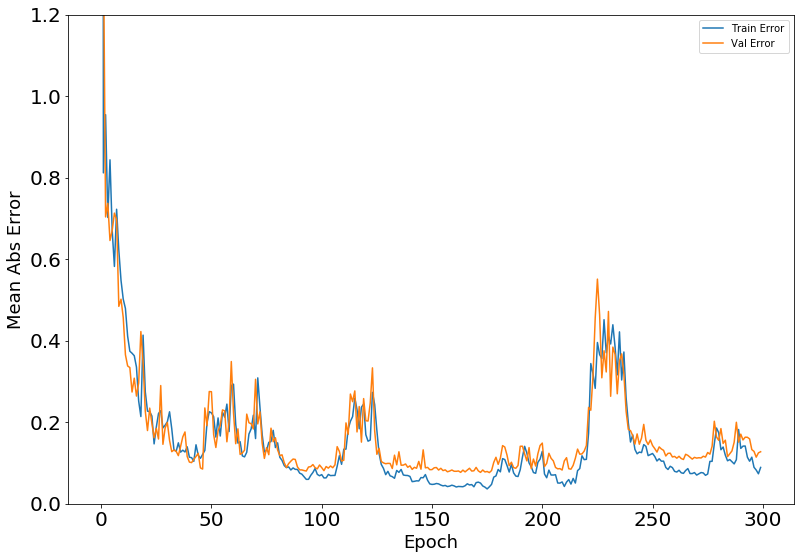

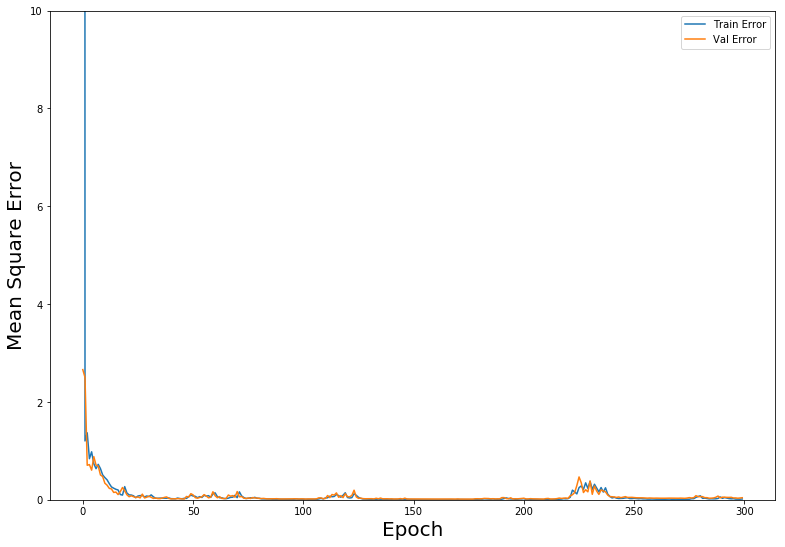

In [455]:
def plot_history(history):
  hist = pd.DataFrame(history.history)
  hist['epoch'] = history.epoch
    
  plt.figure(figsize=(13,9))
  #plt.figure()
  plt.xlabel('Epoch', fontsize= 18)
  plt.ylabel('Mean Abs Error', fontsize= 18)
  plt.plot(hist['epoch'], hist['mean_absolute_error'],
           label='Train Error')
  plt.plot(hist['epoch'], hist['val_mean_absolute_error'],
           label = 'Val Error')
  plt.ylim([0,1.2])
  plt.tick_params(labelsize=20)
  plt.legend()
  

  plt.figure(figsize=(13,9))
  #plt.figure()
  plt.xlabel('Epoch', fontsize = 20)
  plt.ylabel('Mean Square Error', fontsize= 20)
  plt.plot(hist['epoch'], hist['mean_squared_error'],
           label='Train Error')
  plt.plot(hist['epoch'], hist['val_mean_squared_error'],
           label = 'Val Error')
  plt.ylim([0,10])
  plt.legend()
  plt.show()


plot_history(history)

**Save model**

(337, 2)
(337,)
(337,)


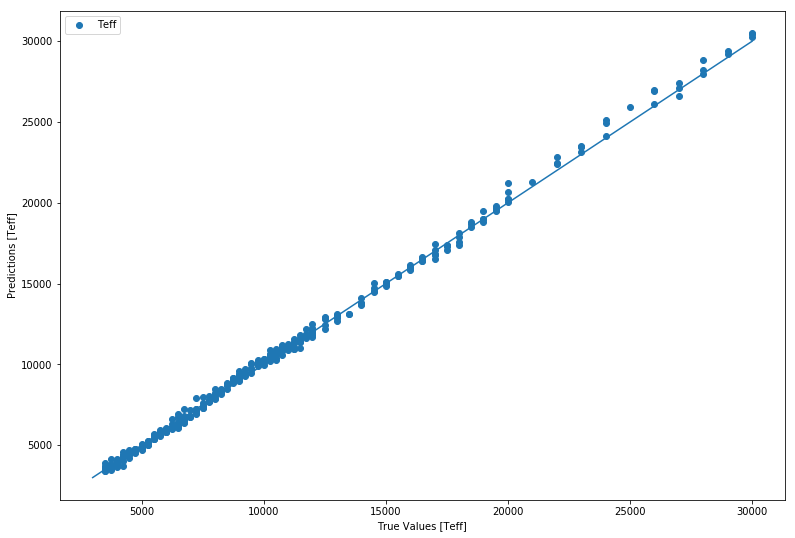

In [456]:
test_predictions = model.predict([x_RVStrain, x_BPtrain, x_RPtrain])
print(np.shape(test_predictions))
print(np.shape(y_train_stack[:,0]))
print(np.shape(y_train_stack[:,1]))
plt.figure(figsize=(13,9))
plt.scatter((denormalize(y_train_stack[:,0], mean_teff_train, std_teff_train )), denormalize(test_predictions[:,0], mean_teff_train, std_teff_train), label= 'Teff')
#plt.scatter((denormalize(y_train_stack[:,1], mean_logg, std_logg)), denormalize(test_predictions[:,1], mean_logg, std_teff), label= 'Log(g)')
plt.xlabel('True Values [Teff]')
plt.ylabel('Predictions [Teff]')
#plt.axis('equal')
#plt.axis('square')
plt.legend()
#plt.xlim([0,plt.xlim()[1]])
#plt.ylim([0,plt.ylim()[1]])
_ = plt.plot([3000, 30000], [3000, 30000])
plt.show()

#print('test predictions=', test_predictions)

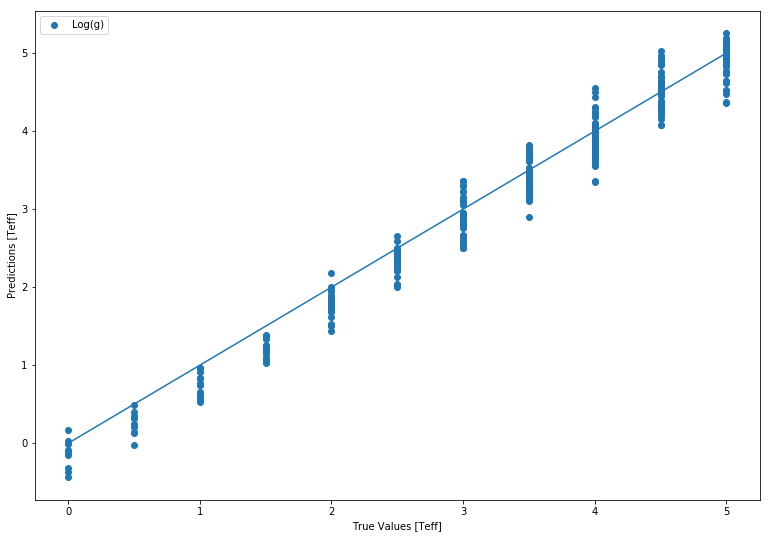

In [457]:
plt.figure(figsize=(13,9))
plt.scatter((denormalize(y_train_stack[:,1], mean_logg_train, std_logg_train)), denormalize(test_predictions[:,1], mean_logg_train, std_logg_train), label= 'Log(g)')
plt.xlabel('True Values [Teff]')
plt.ylabel('Predictions [Teff]')
_ = plt.plot([0, 5], [0, 5])
plt.legend()
plt.show()

In [458]:
#Unnormalizing the labels (teff)
''''
print(np.shape(y_train_stack[:,0]), y_train_stack[:,0])
print(np.shape(y_train_stack[:,1]))





plt.figure(figsize=(13,9))
test_predictions = model.predict([x_RVStrain, x_BPtrain, x_RPtrain])
print('shape of test_predictions:',np.shape(test_predictions))
print('print 10 elements of test_predictions:', test_predictions[0:10])
plt.scatter(denormalize(y_train_stack[:,0]), denormalize(test_predictions[:,0]), s= 4.0, c= 'r', label='Teff' )

print('teff',denormalize(y_train_stack[:,0]))
#plt.scatter(denormalize(y_train_stack[:,1]), denormalize(test_predictions[:,1]), s= 4.0, c= 'b', label='Log(g)' )
plt.xlabel(r"True", fontsize=25)
plt.ylabel(r"Prediction", fontsize=25)
plt.axis('equal')
plt.axis('square')
# increase the x,y tick label size
plt.tick_params(labelsize= 25) 
#plt.xlim([0,plt.xlim()[1]])
#plt.ylim([0,plt.ylim()[1]])
_ = plt.plot([-2, 4], [-2, 4], color='green')
plt.legend(fontsize=20)

'''''



'\'\nprint(np.shape(y_train_stack[:,0]), y_train_stack[:,0])\nprint(np.shape(y_train_stack[:,1]))\n\n\n\n\n\nplt.figure(figsize=(13,9))\ntest_predictions = model.predict([x_RVStrain, x_BPtrain, x_RPtrain])\nprint(\'shape of test_predictions:\',np.shape(test_predictions))\nprint(\'print 10 elements of test_predictions:\', test_predictions[0:10])\nplt.scatter(denormalize(y_train_stack[:,0]), denormalize(test_predictions[:,0]), s= 4.0, c= \'r\', label=\'Teff\' )\n\nprint(\'teff\',denormalize(y_train_stack[:,0]))\n#plt.scatter(denormalize(y_train_stack[:,1]), denormalize(test_predictions[:,1]), s= 4.0, c= \'b\', label=\'Log(g)\' )\nplt.xlabel(r"True", fontsize=25)\nplt.ylabel(r"Prediction", fontsize=25)\nplt.axis(\'equal\')\nplt.axis(\'square\')\n# increase the x,y tick label size\nplt.tick_params(labelsize= 25) \n#plt.xlim([0,plt.xlim()[1]])\n#plt.ylim([0,plt.ylim()[1]])\n_ = plt.plot([-2, 4], [-2, 4], color=\'green\')\nplt.legend(fontsize=20)\n\n'

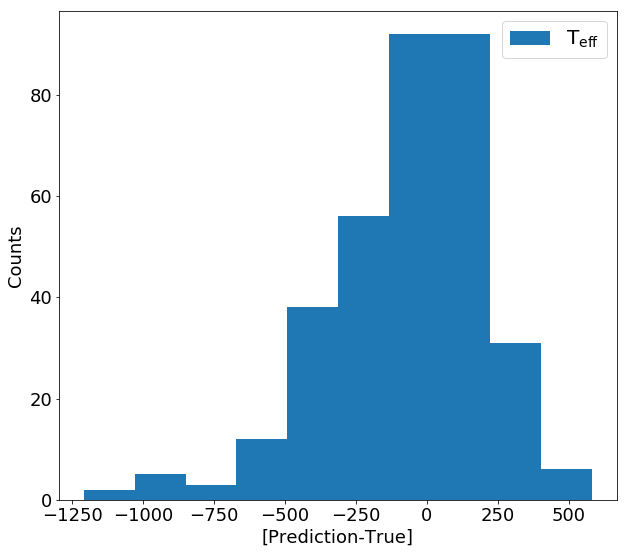

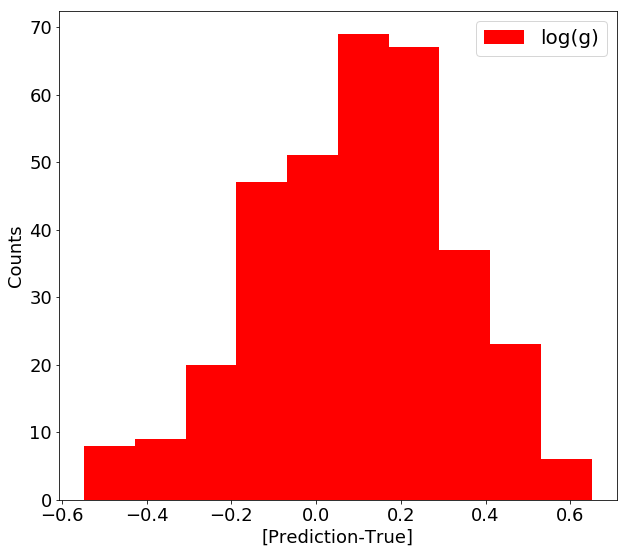

In [459]:
#Making the histogram of denormalized training set 

plt.figure(figsize=(10,9))
data_teff=np.subtract(denormalize(y_train_stack[:,0], mean_teff_train, std_teff_train), denormalize(test_predictions[:,0], mean_teff_train, std_teff_train)) 
data_logg=np.subtract(denormalize(y_train_stack[:,1], mean_logg_train, std_logg_train), denormalize(test_predictions[:,1], mean_logg_train, std_logg_train)) 

counts_teff, bins_teff = np.histogram(data_teff)
counts_logg, bins_logg = np.histogram(data_logg)

#histogram for LogTeff
plt.hist(bins_teff[:-1], bins_teff, weights=counts_teff, label= r'$\rm T_{\rm eff}$')
plt.tick_params(labelsize=18) 
plt.xlabel(r'[Prediction-True]', fontsize=18)
plt.ylabel('Counts', fontsize=18)
plt.legend(fontsize=20)
plt.show()

#histogram for Log(g)
plt.figure(figsize=(10,9))
plt.hist(bins_logg[:-1], bins_logg, weights=counts_logg, label= 'log(g)', color='red')
plt.tick_params(labelsize=18) 
plt.xlabel(r'[Prediction-True]', fontsize=18)
plt.ylabel('Counts', fontsize=18)
plt.legend(fontsize=20)
plt.show()




#print('standard deviation', len(z))
#print(len(z[teff<5000]))
#print(len(z))


# Training Data Set

In [461]:
# getting deviation in Teff bins

teffbin_edges=np.array( [4000, 5000, 6000, 7000, 8000, 9000, 10000, 11000, 12000, 13000, 14000, 15000, 16000, 17000, 18000])
nbin = len(teffbin_edges)


# pred vs. true
# unnormalised values
teff_pred = denormalize(test_predictions[:,0], mean_teff_train, std_teff_train)
teff_true = denormalize(y_train_stack[:,0], mean_teff_train, std_teff_train) #teff values are created by read_spectra1_updatedwavelength from the nsc Allende Prieto spectra library
teff_diff = teff_pred-teff_true

# compute mean and std in Teff bins
teff_diff_mean = np.zeros(nbin) 
teff_diff_std = np.zeros(nbin)
teffbin_mean = np.zeros(nbin)

for i in range(nbin): #iterations(0,1,2,3,4)
    if i==0:
        indx = np.where(teff_true<teffbin_edges[i]) #index of teff_true where teff true< 5000 since teff has all values of teff in each library
        #print(indx)
    elif i==nbin-1: #if i= 5-1= 4
        indx = np.where(teff_true>teffbin_edges[i-1]) #index of true_teff>20000
    else: #if i=1,2,3
        indx = np.where((teff_true>teffbin_edges[i-1]) & (teff_true<teffbin_edges[i]))
        #if i=1, teff_true>(teffbin_edges[1-1=0]= 5000) & teff_true<teffbin_edges[1]= 10000, so 5000<teff<10000
        #if i=2, teff_true>(teffbin_edges[2-1=1]=10000) & teff_true<teffbin_edges[2]= 15000, so 10000<teff<15000
        #if i=3, teff_true> (teffbin_edges[3-1=2]= 15000) & teff_true<teffbin_edges[3]= 20000 so 15000<teff<20000
    teffbin_mean[i] = np.mean(teff_true[indx]) #calculating the mean values of teff_true from assigning its index in the for loop
    teff_diff_mean[i] = np.mean(teff_diff[indx]) #calculating the mean values of teff_diff from its index 
    teff_diff_std[i] = np.std(teff_diff[indx]) #calculating the std values of teff-diff from its index
    
print('mean of bin teff_true=', teffbin_mean)
print('mean of teff_diff=', teff_diff_mean)
print('std of teff_diff=', teff_diff_std)
print('length of teff_diff=', len(teff_diff))

####################################################################################################################
print('==========================================================================================================')
# getting deviation in Teff bins
nbin = len(loggbin_edges)
loggbin_edges=np.array([ -2, -1, 0, 1, 2, 3, 4, 5])

# pred vs. true
# unnormalised values
logg_pred = denormalize(test_predictions[:,1], mean_logg_train, std_logg_train)
logg_true = denormalize(y_train_stack[:,1], mean_logg_train, std_logg_train) #teff values are created by read_spectra1_updatedwavelength from the nsc Allende Prieto spectra library
logg_diff = logg_pred-logg_true

# compute mean and std in Teff bins
logg_diff_mean = np.zeros(nbin) 
logg_diff_std = np.zeros(nbin)
loggbin_mean = np.zeros(nbin)

for i in range(nbin): #iterations(0,1,2,3,4)
    if i==0:
        indx = np.where(logg_true<loggbin_edges[i]) #index of teff_true where teff true< 5000 since teff has all values of teff in each library
        #print(indx)
    elif i==nbin-1: #if i= 5-1= 4
        indx = np.where(logg_true>loggbin_edges[i-1]) #index of true_teff>20000
    else: #if i=1,2,3
        indx = np.where((logg_true>loggbin_edges[i-1]) & (logg_true<loggbin_edges[i]))

    loggbin_mean[i] = np.mean(logg_true[indx]) #calculating the mean values of teff_true from assigning its index in the for loop
    logg_diff_mean[i] = np.mean(logg_diff[indx]) #calculating the mean values of teff_diff from its index 
    logg_diff_std[i] = np.std(logg_diff[indx]) #calculating the std values of teff-diff from its index
    
print('mean of bin logg_true=', loggbin_mean)
print('mean of logg_diff=', logg_diff_mean)
print('std of logg_diff=', logg_diff_std)
print('length of logg_diff=', len(logg_diff))









mean of bin teff_true= [ 3750.          4531.25        5482.75862069  6550.
  7500.          8513.88888889  9517.85714286 10487.5
 11485.29411765 12500.         13500.         14500.
 15500.         16500.         22357.14285714]
mean of teff_diff= [ -22.02622768  -29.80863444  -35.97183122  -85.18400879   -5.81705729
  198.99734158  287.68994141  208.12016602    1.73667279  146.04648438
 -393.82373047  199.2043457    10.37792969   18.6015625   270.01969069]
std of teff_diff= [170.72980686 178.26164003 110.17351435 268.75236502 233.57972911
 131.16673157 195.22501229 222.65531927 235.72011857 274.8368467
   4.66650391 213.42056538  64.31158584 106.05651458 408.41307606]
length of teff_diff= 337
mean of bin logg_true= [nan nan nan 0.5 1.5 2.5 3.5 4.5 nan]
mean of logg_diff= [        nan         nan         nan -0.24336902 -0.2845142  -0.16263506
 -0.05849115  0.0116696          nan]
std of logg_diff= [       nan        nan        nan 0.13455192 0.10882694 0.16179242
 0.22021893 0.252364

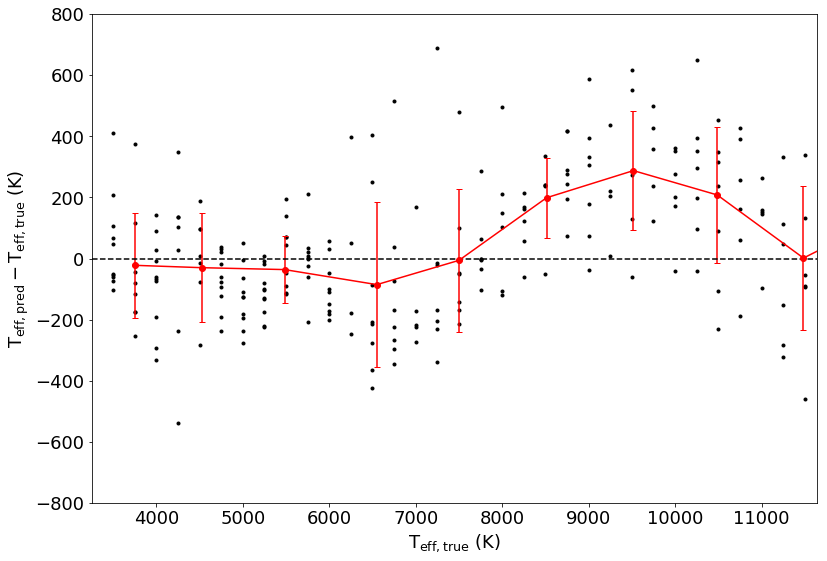

In [465]:
# plot of teff
plt.figure(figsize=(13,9))
# plot the difference
plt.scatter(teff_true, teff_diff ,c='k', marker='.')
#plt.plot(teff_true, teff_diff,'o', markersize=1, c='k')

# plot mean (symbol) and scatter with error bars
plt.errorbar(teffbin_mean, teff_diff_mean, yerr=teff_diff_std, fmt='-o', c='r',capsize=3) #plotting the teff bin mean in x-axis and teff_diff in y-axis

# increase the x,y tick label size
plt.tick_params(labelsize=18) 

# set x, y label. 
plt.xlabel(r"$T_{\rm eff,true}$ (K)", fontsize=18)
plt.ylabel(r"$T_{\rm eff,pred}-T_{\rm eff,true}$ (K)", fontsize=18)

# set x, y lim plot range
xlim=np.array([3250, 11640.76923077])
ylim=np.array([-800, 800])
plt.xlim(xlim[0],xlim[1]) #plotting the xlim
plt.ylim(ylim[0],ylim[1])

# set x, y label. 
plt.xlabel(r"$\rm T_{\rm eff,true}$ (K)", fontsize=18)
plt.ylabel(r"$\rm T_{\rm eff,pred}-\rm T_{\rm eff,true}$ (K)", fontsize=18)

# draw y=0 line
xline = np.linspace(xlim[0],xlim[1], 2)
yline = np.zeros_like(xline)
plt.plot(xline,yline,linestyle='--',c='k')





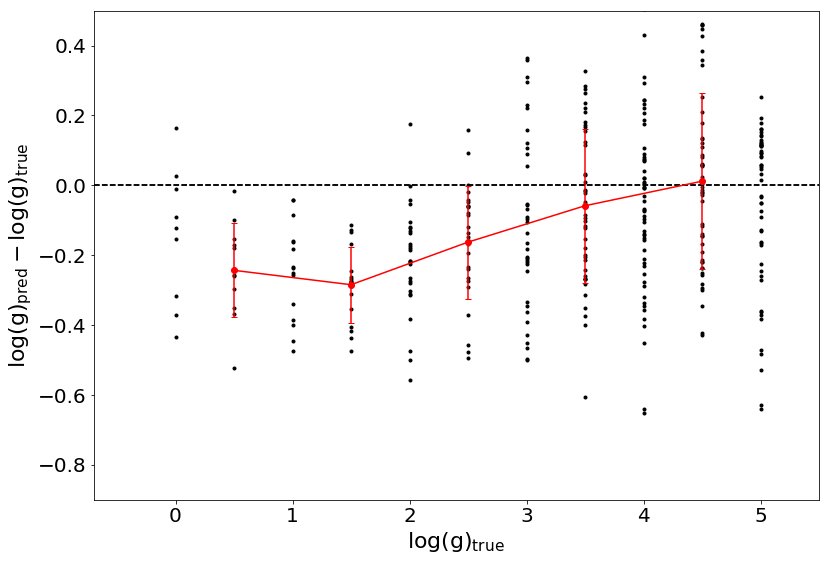

In [467]:
#Plot log 
plt.figure(figsize=(13,9))
# plot the difference
plt.scatter(logg_true, logg_diff ,c='k', marker='.')
#plt.plot(teff_true, teff_diff,'o', markersize=1, c='k')

# plot mean (symbol) and scatter with error bars
plt.errorbar(loggbin_mean,logg_diff_mean, yerr=logg_diff_std, fmt='-o', c='r',capsize=3) #plotting the teff bin mean in x-axis and teff_diff in y-axis

# increase the x,y tick label size
plt.tick_params(labelsize=20) 

# set x, y label. 
#plt.xlabel(r"$T_{\rm eff,true}$ (K)", fontsize=18)
#plt.ylabel(r"$T_{\rm eff,pred}-T_{\rm eff,true}$ (K)", fontsize=18)

# set x, y lim plot range
xlim=np.array([-0.7, 5.5])
ylim=np.array([-0.9, 0.5])
plt.xlim(xlim[0],xlim[1]) #plotting the xlim
plt.ylim(ylim[0],ylim[1])

# draw y=0 line
xline = np.linspace(xlim[0], xlim[1],2 )
yline = np.zeros_like(xline)
plt.plot(xline,yline,linestyle='--',c='k')

# set x, y label. 
plt.xlabel(r"$\rm log(g)_{\rm true}$", fontsize=22)
plt.ylabel(r"$\rm log(g)_{\rm pred}-\rm log(g)_{\rm true}$", fontsize=22)



# draw y=0 line
xline = np.linspace(xlim[0],xlim[1], 2)
yline = np.zeros_like(xline)
plt.plot(xline,yline,linestyle='--',c='k')




# Cross Validation Set

(78, 2)
(337,)
(337,)


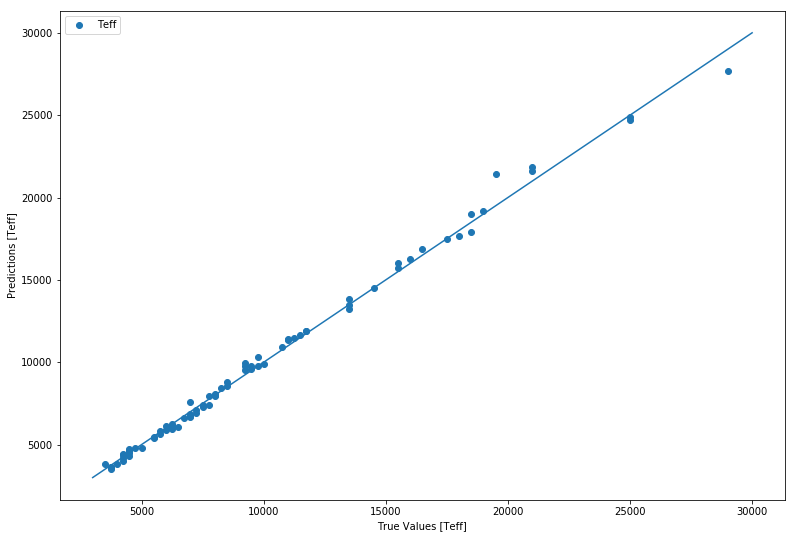

In [468]:
#Test set (x_cv)

test_predictions = model.predict([x_RVScv, x_BPcv, x_RPcv])
print(np.shape(test_predictions))
print(np.shape(y_train_stack[:,0]))
print(np.shape(y_train_stack[:,1]))
plt.figure(figsize=(13,9))
plt.scatter((denormalize(y_cv_stack[:,0], mean_teff_train, std_teff_train )), denormalize(test_predictions[:,0], mean_teff_train, std_teff_train), label= 'Teff')
#plt.scatter((denormalize(y_train_stack[:,1], mean_logg, std_logg)), denormalize(test_predictions[:,1], mean_logg, std_teff), label= 'Log(g)')
plt.xlabel('True Values [Teff]')
plt.ylabel('Predictions [Teff]')
#plt.axis('equal')
#plt.axis('square')
plt.legend()
_ = plt.plot([3000, 30000], [3000, 30000])
plt.show()
#plt.xlim([0,plt.xlim()[1]])
#plt.ylim([0,plt.ylim()[1]])
#_ = plt.plot([1.4, 1.4], [1.4, 1.4])

#print('test predictions=', test_predictions)


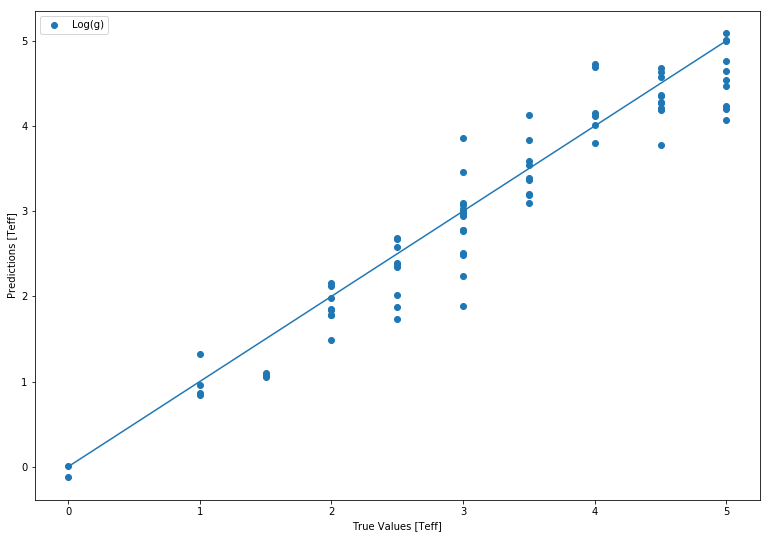

In [469]:
plt.figure(figsize=(13,9))
plt.scatter((denormalize(y_cv_stack[:,1], mean_logg_train, std_logg_train)), denormalize(test_predictions[:,1], mean_logg_train, std_logg_train), label= 'Log(g)')
plt.xlabel('True Values [Teff]')
plt.ylabel('Predictions [Teff]')
_ = plt.plot([0, 5], [0, 5])
plt.legend()
plt.show()

In [503]:
# getting deviation in Teff bins
teffbin_edges=np.array( [4000, 5000, 6000,  7000, 8000,  9000,  10000,  12000, 13000])
nbin = len(teffbin_edges)


# pred vs. true
# unnormalised values
teff_pred = denormalize(test_predictions[:,0], mean_teff_train, std_teff_train)
teff_true = denormalize(y_cv_stack[:,0], mean_teff_train, std_teff_train) #teff values are created by read_spectra1_updatedwavelength from the nsc Allende Prieto spectra library
teff_diff = teff_pred-teff_true

print(' Teff diff mean and std for Teff<11000=', np.mean(teff_diff[(teff_true>4000) & (teff_true<11000.0)]), 
      np.std(teff_diff[(teff_true>4000) & (teff_true<11000.0)]),
      len(teff_diff[(teff_true>4000) & (teff_true<11000.0)]))

print(' Teff diff mean and std for Teff<5000=', np.mean(teff_diff[(teff_true>3750) & (teff_true<5000)]), 
      np.std(teff_diff[(teff_true>3750) & (teff_true<5000)]),
      len(teff_diff[(teff_true>3750) & (teff_true<5000)]))

# compute mean and std in Teff bins
teff_diff_mean = np.zeros(nbin) 
teff_diff_std = np.zeros(nbin)
teffbin_mean = np.zeros(nbin)

for i in range(nbin): #iterations(0,1,2,3,4)
    if i==0:
        indx = np.where(teff_true<teffbin_edges[i]) #index of teff_true where teff true< 5000 since teff has all values of teff in each library
        #print(indx)
    elif i==nbin-1: #if i= 5-1= 4
        indx = np.where(teff_true>teffbin_edges[i-1]) #index of true_teff>20000
    else: #if i=1,2,3
        indx = np.where((teff_true>teffbin_edges[i-1]) & (teff_true<teffbin_edges[i]))
        #if i=1, teff_true>(teffbin_edges[1-1=0]= 5000) & teff_true<teffbin_edges[1]= 10000, so 5000<teff<10000
        #if i=2, teff_true>(teffbin_edges[2-1=1]=10000) & teff_true<teffbin_edges[2]= 15000, so 10000<teff<15000
        #if i=3, teff_true> (teffbin_edges[3-1=2]= 15000) & teff_true<teffbin_edges[3]= 20000 so 15000<teff<20000
    teffbin_mean[i] = np.mean(teff_true[indx]) #calculating the mean values of teff_true from assigning its index in the for loop
    teff_diff_mean[i] = np.mean(teff_diff[indx]) #calculating the mean values of teff_diff from its index 
    teff_diff_std[i] = np.std(teff_diff[indx]) #calculating the std values of teff-diff from its index
    
print('mean of bin teff_true=', teffbin_mean)
print('mean of teff_diff=', teff_diff_mean)
print('std of teff_diff=', teff_diff_std)
print('length of teff_diff=', len(teff_diff))

####################################################################################################################
print('==========================================================================================================')
# getting deviation in Teff bins

loggbin_edges=np.array([   1, 2, 3, 4, 5, 6])
nbin = len(loggbin_edges)

# pred vs. true
# unnormalised values
logg_pred = denormalize(test_predictions[:,1], mean_logg_train, std_logg_train)
logg_true = denormalize(y_cv_stack[:,1], mean_logg_train, std_logg_train) #teff values are created by read_spectra1_updatedwavelength from the nsc Allende Prieto spectra library
logg_diff = logg_pred-logg_true

print(' logg diff mean and std for 2<logg<5=', np.mean(logg_diff[(logg_true >2) & (logg_true<5)]),
       np.std(logg_diff[(logg_true>2) & (logg_true<5)]),
      len(logg_diff[(logg_true>2) & (logg_true<5)]))

# compute mean and std in Teff bins
logg_diff_mean = np.zeros(nbin) 
logg_diff_std = np.zeros(nbin)
loggbin_mean = np.zeros(nbin)

for i in range(nbin): #iterations(0,1,2,3,4)
    if i==0:
        indx = np.where(logg_true<loggbin_edges[i]) #index of teff_true where teff true< 5000 since teff has all values of teff in each library
        #print(indx)
    elif i==nbin-1: #if i= 5-1= 4
        indx = np.where(logg_true>loggbin_edges[i-1]) #index of true_teff>20000
    else: #if i=1,2,3
        indx = np.where((logg_true>loggbin_edges[i-1]) & (logg_true<loggbin_edges[i]))

    loggbin_mean[i] = np.mean(logg_true[indx]) #calculating the mean values of teff_true from assigning its index in the for loop
    logg_diff_mean[i] = np.mean(logg_diff[indx]) #calculating the mean values of teff_diff from its index 
    logg_diff_std[i] = np.std(logg_diff[indx]) #calculating the std values of teff-diff from its index
    
print('mean of bin logg_true=', loggbin_mean)
print('mean of logg_diff=', logg_diff_mean)
print('std of logg_diff=', logg_diff_std)
print('length of logg_diff=', len(logg_diff))







        

 Teff diff mean and std for Teff<11000= 13.613250732421951 250.58622793610252 48
 Teff diff mean and std for Teff<5000= -1.9083496093745453 149.80593204384965 10
mean of bin teff_true= [ 3750.          4416.66666667  5625.          6357.14285714
  7500.          8416.66666667  9464.28571429 11285.71428571
 18447.36842105]
mean of teff_diff= [ -49.71064453   14.54546441  -34.7130127  -183.87674386 -150.30118815
  181.67447917  355.71512277  235.66531808  151.53973067]
std of teff_diff= [187.22781433 149.09081987  64.62278747 137.36125808 176.23700383
 117.11269434 245.91256635  95.36497644 631.61552529]
length of teff_diff= 78
 logg diff mean and std for 2<logg<5= -0.09154369784336464 0.3787998183325653 51
mean of bin logg_true= [0.  1.5 2.5 3.5 4.5 nan]
mean of logg_diff= [-0.05642068 -0.41907183 -0.20414163 -0.0191248  -0.17799733         nan]
std of logg_diff= [0.06445301 0.0197698  0.32826858 0.31480771 0.24049957        nan]
length of logg_diff= 78


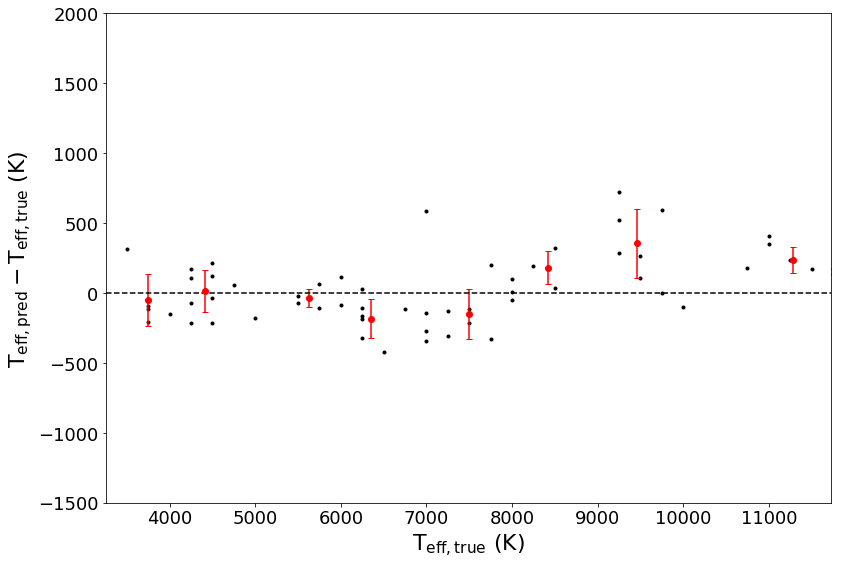

In [501]:
# plot of logteff
plt.figure(figsize=(13,9))
# plot the difference
plt.scatter(teff_true, teff_diff ,c='k', marker='.')
#plt.plot(teff_true, teff_diff,'o', markersize=1, c='k')

# plot mean (symbol) and scatter with error bars
plt.errorbar(teffbin_mean, teff_diff_mean, yerr=teff_diff_std, fmt='o', c='r',capsize=3) #plotting the teff bin mean in x-axis and teff_diff in y-axis

# increase the x,y tick label size
plt.tick_params(labelsize=18) 

# set x, y label. 
plt.xlabel(r"$T_{\rm eff,true}$ (K)", fontsize=22)
plt.ylabel(r"$T_{\rm eff,pred}-T_{\rm eff,true}$ (K)", fontsize=22)

# set x, y lim plot range
xlim=np.array([3250,  11725])
ylim=np.array([-1500, 2000])
plt.xlim(xlim[0],xlim[1]) #plotting the xlim
plt.ylim(ylim[0],ylim[1])

# set x, y label. 
plt.xlabel(r"$\rm T_{\rm eff,true}$ (K)", fontsize=22)
plt.ylabel(r"$\rm T_{\rm eff,pred}-\rm T_{\rm eff,true}$ (K)", fontsize=22)

# draw y=0 line
xline = np.linspace(xlim[0],xlim[1], 2)
yline = np.zeros_like(xline)
plt.plot(xline,yline,linestyle='--',c='k')






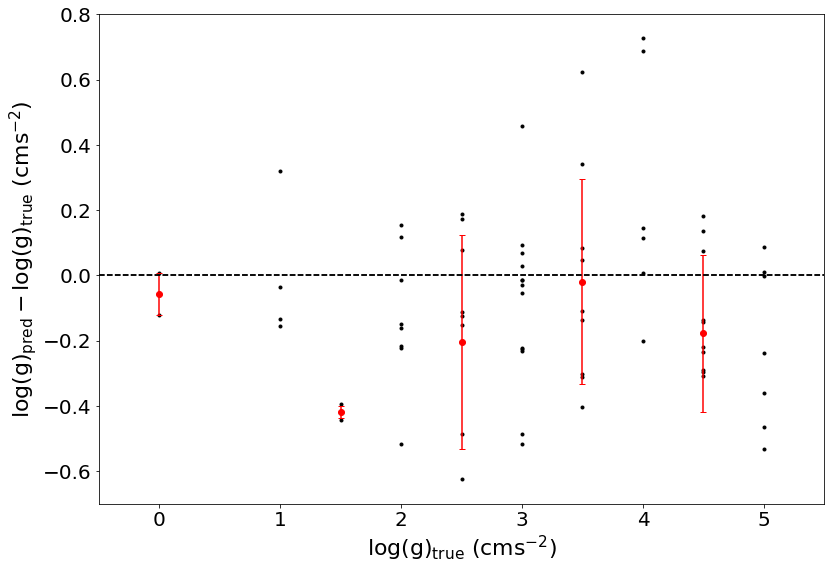

In [506]:
#Plot log 
plt.figure(figsize=(13,9))
# plot the difference
plt.scatter(logg_true, logg_diff ,c='k', marker='.')
#plt.plot(teff_true, teff_diff,'o', markersize=1, c='k')

# plot mean (symbol) and scatter with error bars
plt.errorbar(loggbin_mean,logg_diff_mean, yerr=logg_diff_std, fmt='o', c='r',capsize=3) #plotting the teff bin mean in x-axis and teff_diff in y-axis

# increase the x,y tick label size
plt.tick_params(labelsize=20) 

# set x, y label. 
#plt.xlabel(r"$T_{\rm eff,true}$ (K)", fontsize=18)
#plt.ylabel(r"$T_{\rm eff,pred}-T_{\rm eff,true}$ (K)", fontsize=18)

# set x, y lim plot range
xlim=np.array([-0.5, 5.5])
ylim=np.array([-0.7, 0.8])
plt.xlim(xlim[0],xlim[1]) #plotting the xlim
plt.ylim(ylim[0],ylim[1])

# draw y=0 line
xline = np.linspace(xlim[0], xlim[1],2 )
yline = np.zeros_like(xline)
plt.plot(xline,yline,linestyle='--',c='k')

# set x, y label. 
plt.xlabel(r"$\rm log(g)_{\rm true}$ $(\rm cm s^{-2})$", fontsize=22)
plt.ylabel(r"$\rm log(g)_{\rm pred}-\rm log(g)_{\rm true}$ $(\rm cm s^{-2})$", fontsize=22)



# draw y=0 line
xline = np.linspace(xlim[0],xlim[1], 2)
yline = np.zeros_like(xline)
plt.plot(xline,yline,linestyle='--',c='k')



In [99]:
# Input spectra
input_spec = Input(shape=(num_fluxes,), name='starnet_input_x')

# Reshape spectra for CNN layers
cur_in = Reshape((num_fluxes, 1))(input_spec)

# CNN layers
# First
cur_in = Conv1D(kernel_initializer=initializer, activation=activation, 
                padding="same", filters=128, kernel_size=32)(cur_in) #first CNN layer
# Max pooling layer
cur_in = MaxPooling1D(pool_size=32)(cur_in)
# Second CNN layer
cur_in = Conv1D(kernel_initializer=initializer, activation=activation,
                padding="same", filters=128, kernel_size=16)(cur_in) #2nd CNN layer
# Max pooling layer
cur_in = MaxPooling1D(pool_size=16)(cur_in)
# Third CNN layer
cur_in = Conv1D(kernel_initializer=initializer, activation=activation,
                padding="same", filters=128, kernel_size=8)(cur_in) #2nd CNN layer
# Max pooling layer
cur_in = MaxPooling1D(pool_size=8)(cur_in)

# Flatten the current input for the fully-connected layers
cur_in = Flatten()(cur_in)

# Fully-connected layers
cur_in = Dense(units=258, kernel_initializer=initializer, 
               activation=activation)(cur_in)
cur_in = Dense(units=128, kernel_initializer=initializer, 
               activation=activation)(cur_in)

# Output nodes
output_label = Dense(units=num_labels, kernel_regularizer=keras.regularizers.l2(0.01), activation="linear", 
                     input_dim=num_hidden[1])(cur_in)

model = Model(input_spec, output_label)

ValueError: Negative dimension size caused by subtracting 8 from 1 for 'max_pooling1d_12/MaxPool' (op: 'MaxPool') with input shapes: [?,1,1,128].

In [16]:
optimizer = Adam(lr=0.0005)

In [97]:
# loss function to minimize
loss_function = 'mean_squared_error'
optimizer = 'adadelta'
# compute mean absolute deviation
metrics = ['mae', 'mse']
#metrics = ['mae']
model.compile(optimizer=optimizer, loss=loss_function, metrics=metrics)
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
starnet_input_x (InputLayer) (None, 6758)              0         
_________________________________________________________________
reshape_10 (Reshape)         (None, 6758, 1)           0         
_________________________________________________________________
conv1d_19 (Conv1D)           (None, 6758, 128)         4224      
_________________________________________________________________
max_pooling1d_10 (MaxPooling (None, 211, 128)          0         
_________________________________________________________________
conv1d_20 (Conv1D)           (None, 211, 128)          262272    
_________________________________________________________________
max_pooling1d_11 (MaxPooling (None, 13, 128)           0         
_________________________________________________________________
conv1d_21 (Conv1D)           (None, 13, 128)           131200    
__________

In [ ]:
history = model.fit(x_train, y_train, 
          epochs=max_epochs, validation_split = 0.2, verbose=1, shuffle='batch')

Train on 875 samples, validate on 219 samples
Epoch 1/200
875/875 [==============================] - 13s 15ms/step - loss: 5.2174 - mean_absolute_error: 1.4147 - mean_squared_error: 5.1988 - val_loss: 1.5482 - val_mean_absolute_error: 0.9417 - val_mean_squared_error: 1.5305
Epoch 2/200
875/875 [==============================] - 12s 14ms/step - loss: 0.3955 - mean_absolute_error: 0.5094 - mean_squared_error: 0.3783 - val_loss: 1.8217 - val_mean_absolute_error: 1.0313 - val_mean_squared_error: 1.8050
Epoch 3/200
875/875 [==============================] - 12s 14ms/step - loss: 0.3606 - mean_absolute_error: 0.4579 - mean_squared_error: 0.3443 - val_loss: 1.9750 - val_mean_absolute_error: 1.0742 - val_mean_squared_error: 1.9589
Epoch 4/200
875/875 [==============================] - 12s 14ms/step - loss: 0.3806 - mean_absolute_error: 0.4960 - mean_squared_error: 0.3648 - val_loss: 2.0388 - val_mean_absolute_error: 1.0894 - val_mean_squared_error: 2.0232
Epoch 5/200
875/875 [=================

Epoch 72/200
875/875 [==============================] - 12s 14ms/step - loss: 0.0399 - mean_absolute_error: 0.1346 - mean_squared_error: 0.0361 - val_loss: 1.6221 - val_mean_absolute_error: 0.9613 - val_mean_squared_error: 1.6183
Epoch 73/200
875/875 [==============================] - 13s 14ms/step - loss: 0.0413 - mean_absolute_error: 0.1380 - mean_squared_error: 0.0375 - val_loss: 1.5695 - val_mean_absolute_error: 0.9410 - val_mean_squared_error: 1.5657
Epoch 74/200
875/875 [==============================] - 12s 14ms/step - loss: 0.0508 - mean_absolute_error: 0.1554 - mean_squared_error: 0.0470 - val_loss: 1.6579 - val_mean_absolute_error: 0.9698 - val_mean_squared_error: 1.6541
Epoch 75/200
875/875 [==============================] - 12s 14ms/step - loss: 0.0419 - mean_absolute_error: 0.1415 - mean_squared_error: 0.0381 - val_loss: 1.9499 - val_mean_absolute_error: 1.0596 - val_mean_squared_error: 1.9461
Epoch 76/200
875/875 [==============================] - 12s 14ms/step - loss: 0.

875/875 [==============================] - 12s 13ms/step - loss: 0.0267 - mean_absolute_error: 0.1066 - mean_squared_error: 0.0241 - val_loss: 1.3541 - val_mean_absolute_error: 0.8321 - val_mean_squared_error: 1.3514
Epoch 143/200
875/875 [==============================] - 13s 14ms/step - loss: 0.0540 - mean_absolute_error: 0.1430 - mean_squared_error: 0.0514 - val_loss: 1.8749 - val_mean_absolute_error: 1.0292 - val_mean_squared_error: 1.8723
Epoch 144/200
875/875 [==============================] - 12s 14ms/step - loss: 0.0324 - mean_absolute_error: 0.1221 - mean_squared_error: 0.0298 - val_loss: 1.3159 - val_mean_absolute_error: 0.8185 - val_mean_squared_error: 1.3133
Epoch 145/200
875/875 [==============================] - 12s 14ms/step - loss: 0.0255 - mean_absolute_error: 0.0968 - mean_squared_error: 0.0230 - val_loss: 1.3150 - val_mean_absolute_error: 0.8193 - val_mean_squared_error: 1.3124
Epoch 146/200
875/875 [==============================] - 12s 14ms/step - loss: 0.0254 - me

In [32]:
hist = pd.DataFrame(history.history)
hist['epoch']= history.epoch
hist.tail()

,val_loss,val_mean_absolute_error,val_mean_squared_error,loss,mean_absolute_error,mean_squared_error,epoch
195,6.650632e+07,6355.818481,6.650632e+07,1.702399e+06,881.769361,1.702399e+06,195
196,6.275853e+07,6161.197162,6.275853e+07,1.711892e+06,930.596856,1.711892e+06,196
197,5.944006e+07,5997.135702,5.944006e+07,1.580298e+06,893.164042,1.580298e+06,197
198,6.229281e+07,6138.579988,6.229281e+07,1.912179e+06,979.157146,1.912179e+06,198
199,6.106594e+07,6076.085226,6.106594e+07,1.614590e+06,912.569914,1.614590e+06,199


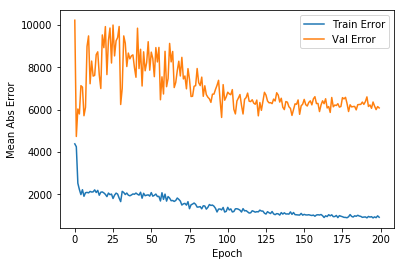

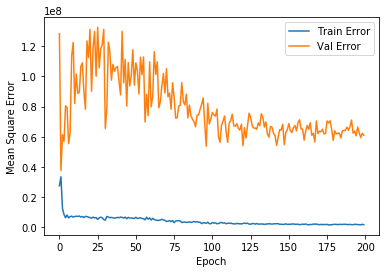

In [33]:
def plot_history(history):
  hist = pd.DataFrame(history.history)
  hist['epoch'] = history.epoch
  
  plt.figure()
  plt.xlabel('Epoch')
  plt.ylabel('Mean Abs Error')
  plt.plot(hist['epoch'], hist['mean_absolute_error'],
           label='Train Error')
  plt.plot(hist['epoch'], hist['val_mean_absolute_error'],
           label = 'Val Error')
  #plt.ylim([0,5])
  plt.legend()
  
  plt.figure()
  plt.xlabel('Epoch')
  plt.ylabel('Mean Square Error')
  plt.plot(hist['epoch'], hist['mean_squared_error'],
           label='Train Error')
  plt.plot(hist['epoch'], hist['val_mean_squared_error'],
           label = 'Val Error')
  #plt.ylim([0,20])
  plt.legend()
  plt.show()


plot_history(history)

test predictions= [ 6836.807   6837.5747  6836.7603 ... 10159.98   12968.633  12631.623 ]


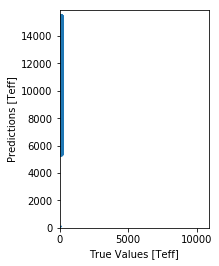

In [34]:
test_predictions = model.predict(norm_flux).flatten()

plt.scatter(normalize(teff), test_predictions)
plt.xlabel('True Values [Teff]')
plt.ylabel('Predictions [Teff]')
plt.axis('equal')
plt.axis('square')
plt.xlim([0,plt.xlim()[1]])
plt.ylim([0,plt.ylim()[1]])
_ = plt.plot([-100, 100], [-100, 100])

print('test predictions=', test_predictions)